In [61]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

import hbsir

from utils import setup_xkcd

setup_xkcd()

In [3]:
YEAR = 1401

In [62]:
def create_data(year):
    return (
        hbsir.load_table("Expenditures", year)
        .pipe(hbsir.add_classification, "Food_NonFood")
        .groupby(["Year", "ID", "Food_NonFood"])["Gross_Expenditure"].sum()
        .unstack()
        .pipe(hbsir.add_weight)
        .pipe(lambda df: df.join(hbsir.calculator.calculate_decile(table=df, on="Income")))
        .eval("""
            Food = Food * Weight
            NonFood = NonFood * Weight
        """)
        .groupby("Decile", observed=True)[["Food", "NonFood", "Weight"]].sum()
        .eval("""
            Food = Food / Weight
            NonFood = NonFood / Weight
            Total = Food + NonFood
        """)
        .loc[:, ["Food", "NonFood", "Total"]]
        .div(1e7)
    )

In [3]:
plot_1 = (
    hbsir.load_table("Total_Income", YEAR)
    .set_index(["Year", "ID"])
    .pipe(lambda df: df.join(hbsir.calculator.calculate_decile(table=df, on="Income")))
    .groupby("Decile", observed=True)["Income"].mean()
    .div(1e7)
)

Text(0, 0.5, 'M Tomans (Current Price)')

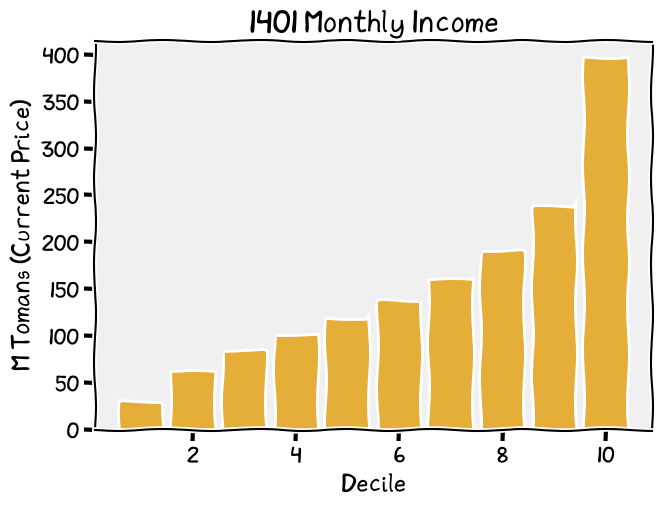

In [4]:
fig, ax = plt.subplots()
ax.bar(plot_1.index, plot_1, color="#e5ae38")

ax.set_title(f"{YEAR} Monthly Income")
ax.set_xlabel("Decile")
ax.set_ylabel("M Tomans (Current Price)")

In [ ]:

for year in range(1383, 1402):
    plot_data = create_data(year)
    fig, ax = plt.subplots()
    dist = plot_data["Total"].max() / 120
    ax.bar(x=plot_data.index, height=plot_data["Food"] - dist, label="Food")
    ax.bar(x=plot_data.index, height=plot_data["NonFood"], bottom=plot_data["Food"] + dist, label="Non-Food")

    ax.set_title(f"{year} Expenditures Breakdown")
    ax.set_xlabel("Decile")
    ax.set_ylabel("M Tomans (Current Price)")
    ax.legend()

    display(fig)
    fig.clear()

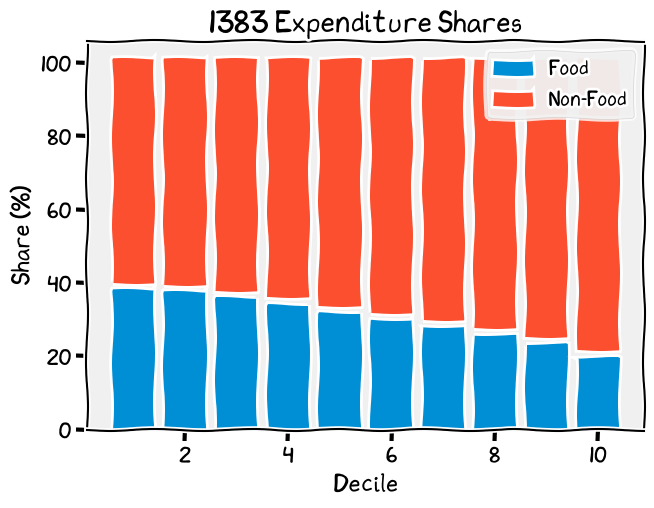

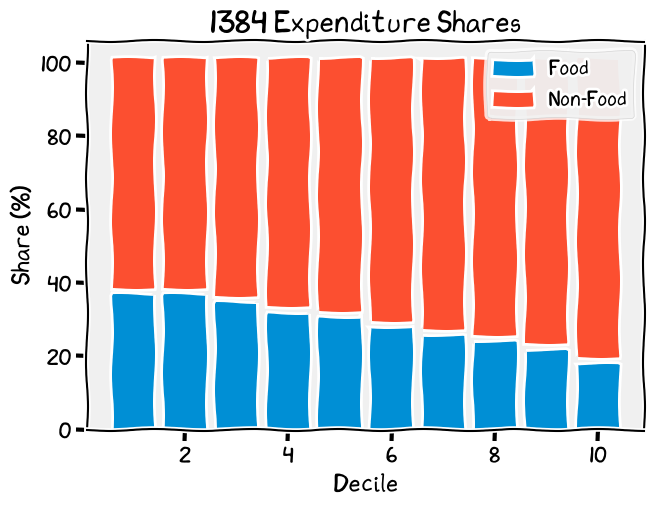

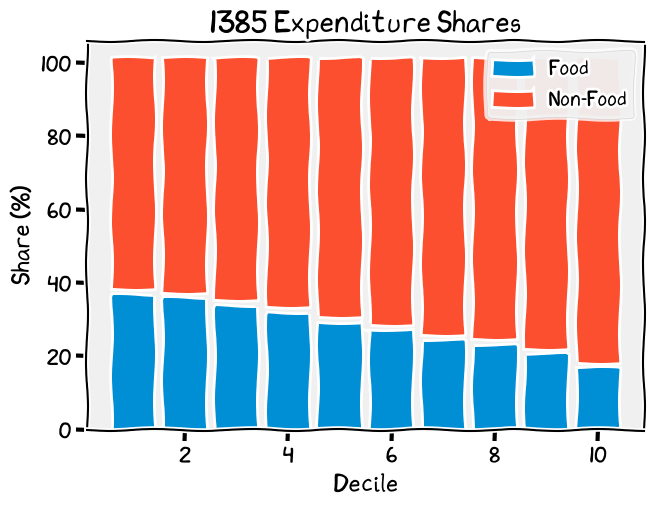

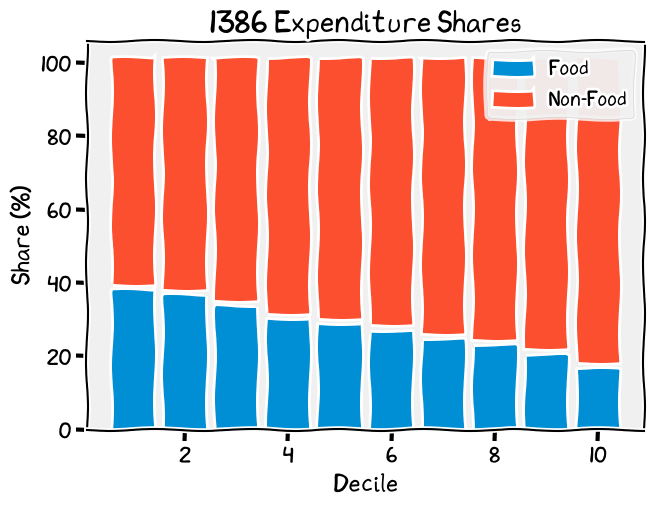

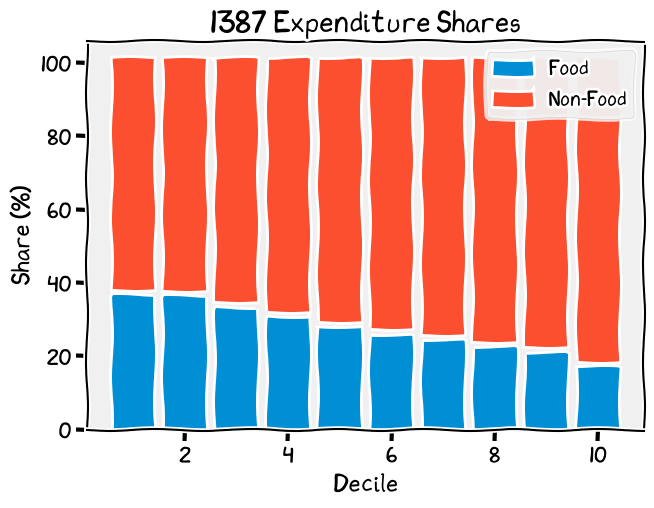

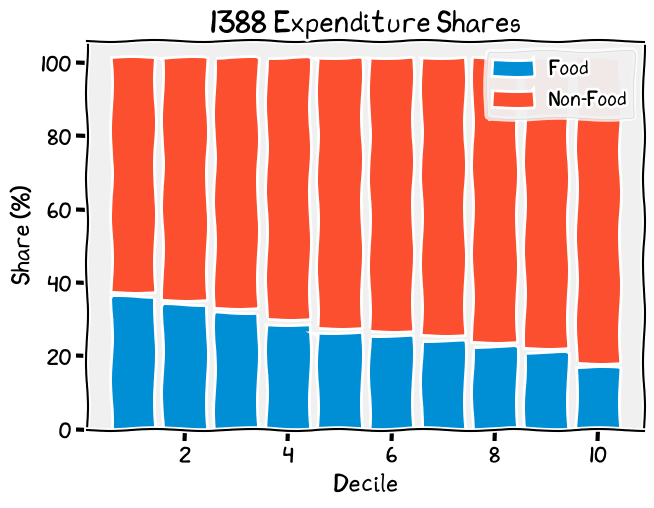

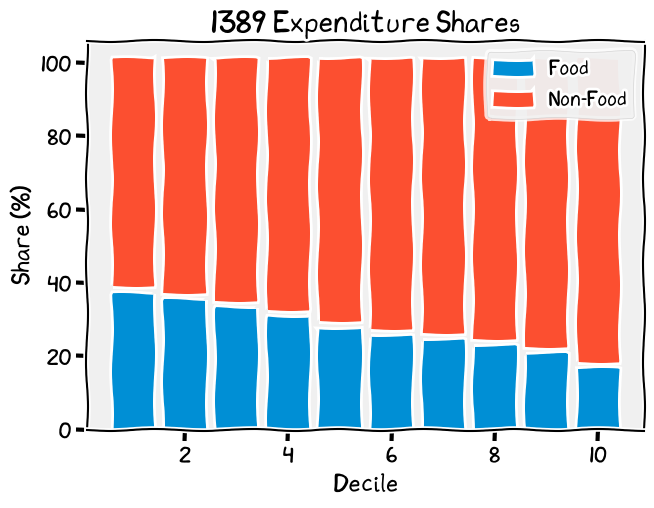

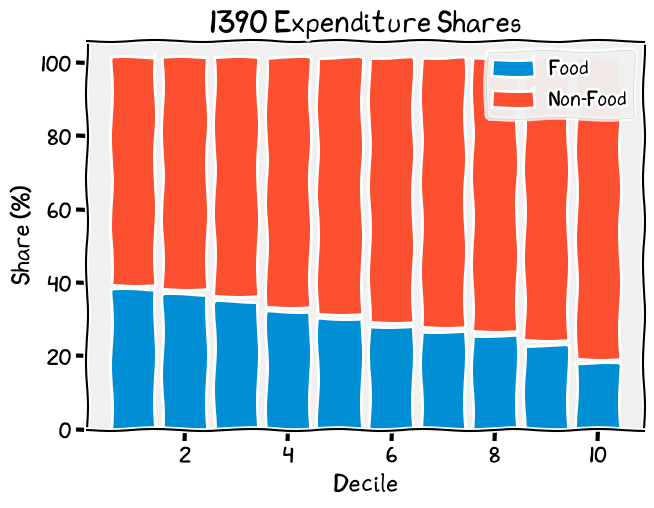

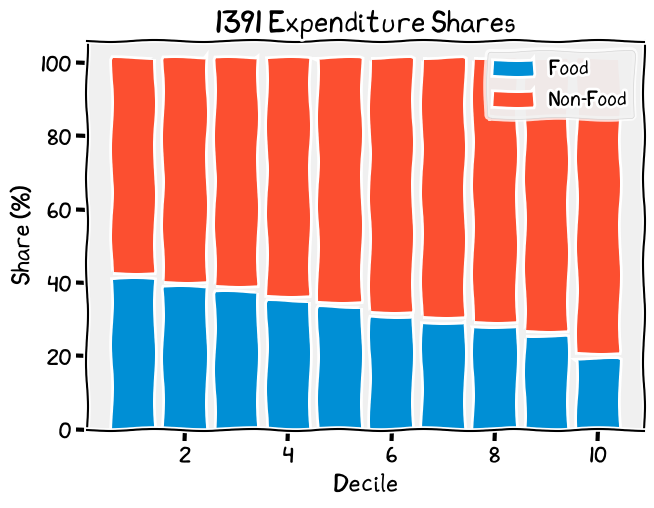

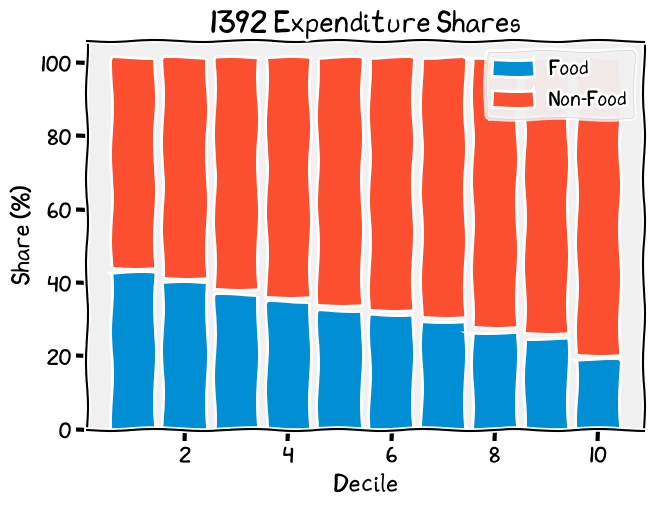

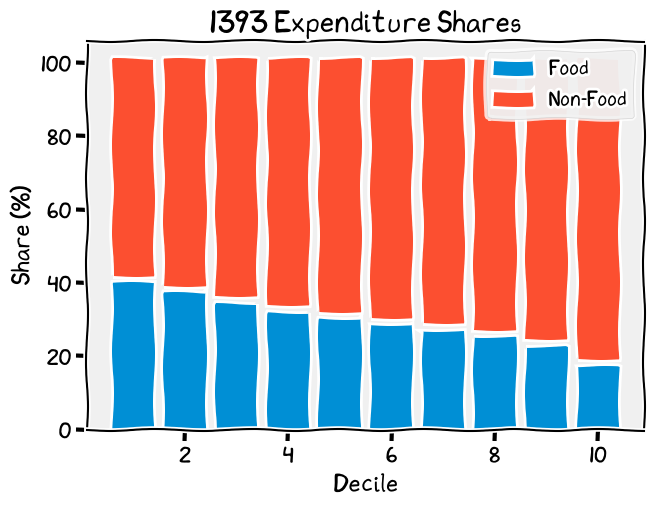

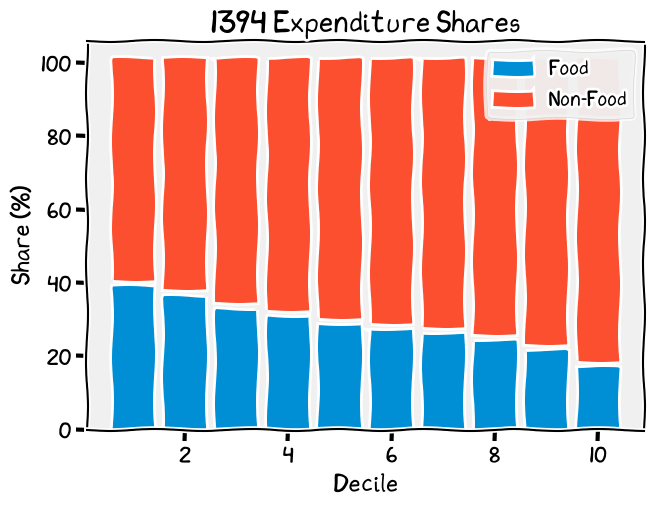

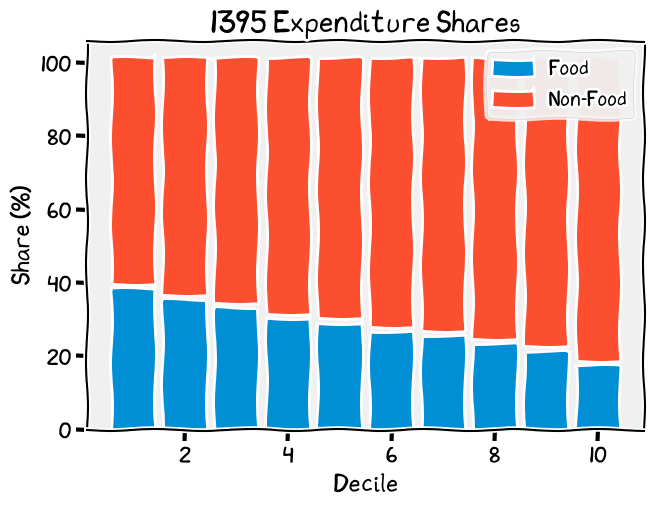

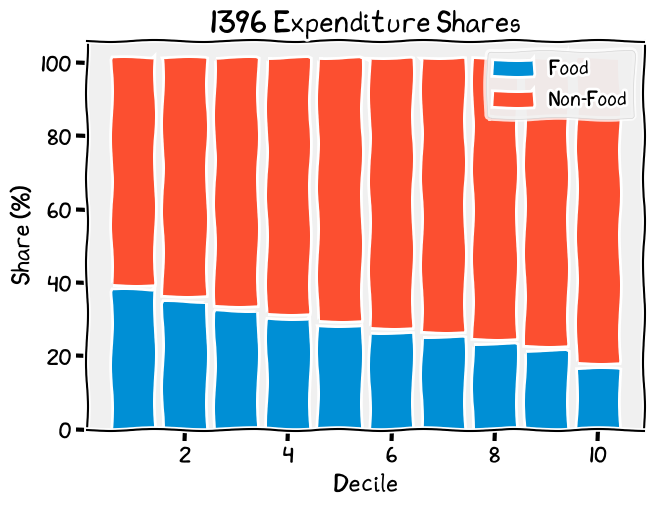

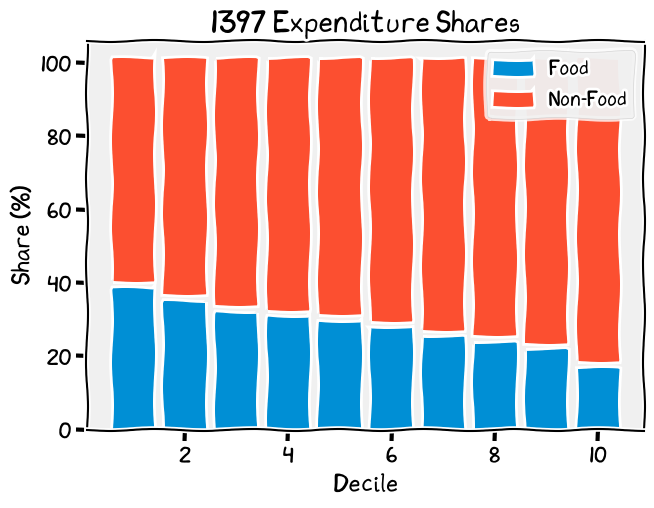

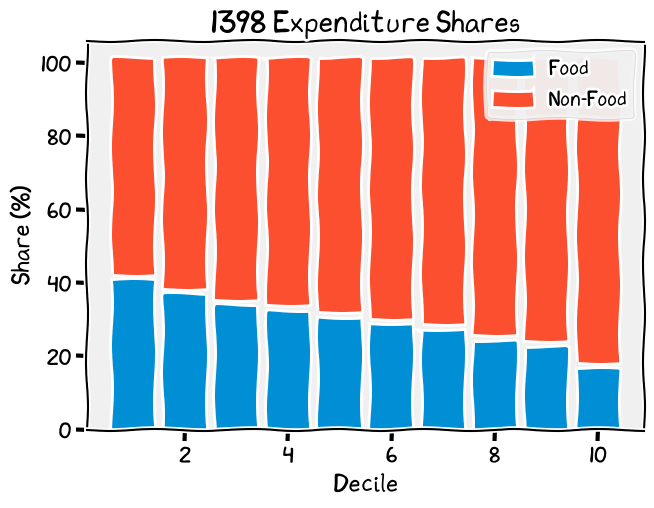

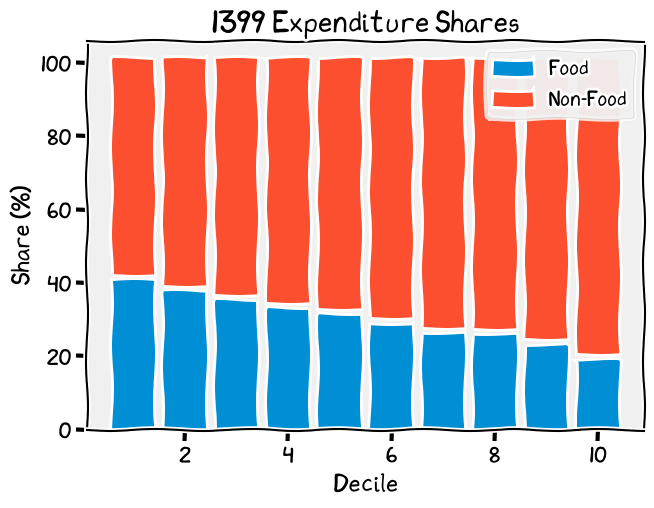

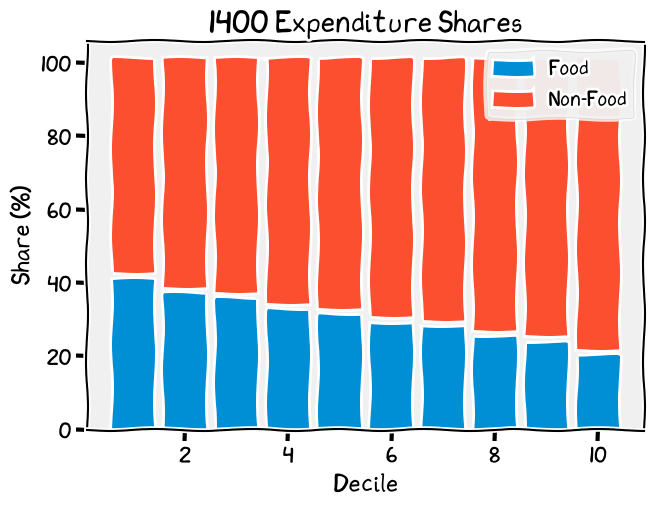

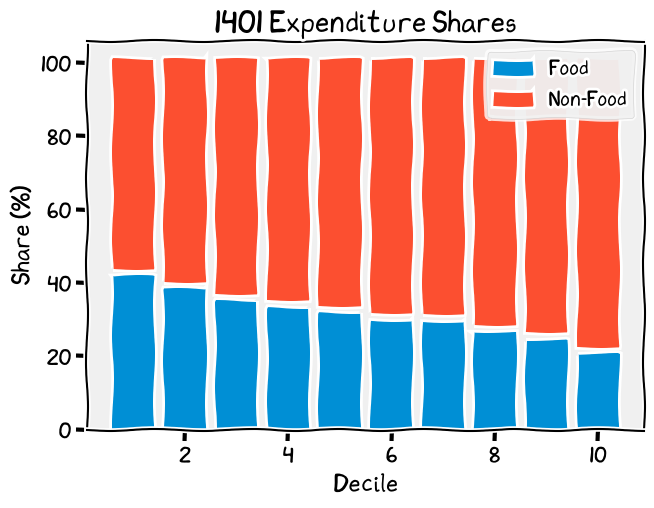

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
for year in range(1383, 1402):
    plot_data = create_data(year)
    fig, ax = plt.subplots()
    ax.bar(
        x=plot_data.index,
        height=plot_data["Food"] / plot_data["Total"] * 100 - 1,
        label="Food"
    )
    ax.bar(
        x=plot_data.index,
        height=plot_data["NonFood"] / plot_data["Total"] * 100,
        bottom=plot_data["Food"] / plot_data["Total"] * 100 + 1,
        label="Non-Food"
    )

    ax.set_title(f"{year} Expenditure Shares")
    ax.set_xlabel("Decile")
    ax.set_ylabel("Share (%)")
    ax.legend()

    display(fig)
    fig.clear()

In [6]:
plot_2 = create_data(YEAR).eval("Food_Share = Food / Total * 100")

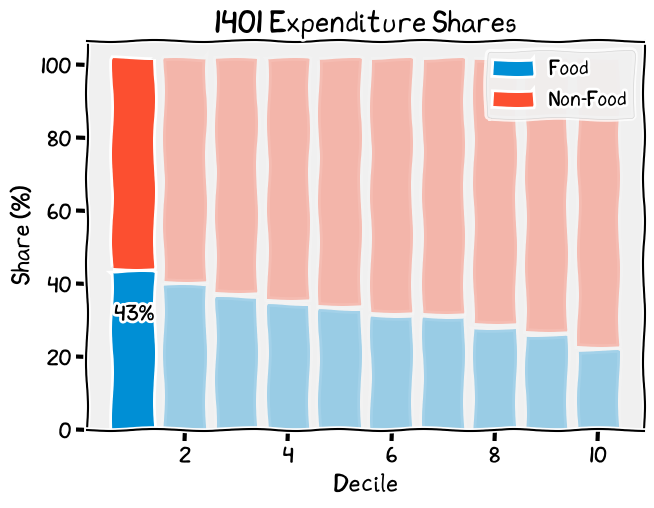

<Figure size 640x480 with 0 Axes>

In [16]:
def select_decile(ax, data, decile):
    ax.bar(
        x=data.index[decile - 1],
        height=data.eval("Food / Total * 100").iloc[decile - 1],
        label="Food"
    )
    ax.bar(
        x=data.index[decile - 1],
        height=data.eval("NonFood / Total * 100").iloc[decile - 1],
        bottom=data.eval("Food / Total * 100 + 1.5").iloc[decile - 1],
        label="Non-Food"
    )
    ax.bar(
        x=data.drop(index=decile).index,
        height=data.drop(index=decile).eval("Food / Total * 100"),
        color="#008fd5",
        alpha=0.2,
    )
    ax.bar(
        x=data.drop(index=decile).index,
        height=data.drop(index=decile).eval("NonFood / Total * 100"),
        bottom=data.drop(index=decile).eval("Food / Total * 100 + 1.5"),
        color="#fc4f30",
        alpha=0.2,
    )


fig, ax = plt.subplots()

select_decile(ax, plot_2, 1)

ax.annotate(f"{round(plot_2.loc[1, 'Food_Share'])}%", (0.63, 30))

ax.set_title(f"{YEAR} Expenditure Shares")
ax.set_xlabel("Decile")
ax.set_ylabel("Share (%)")
ax.legend()

display(fig)
fig.clear()

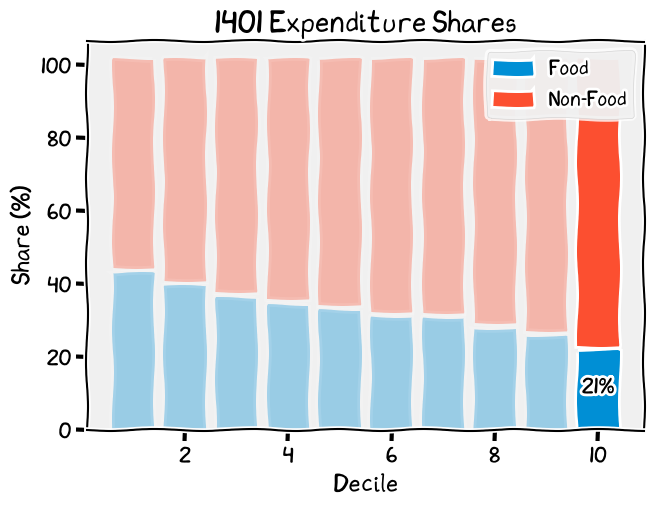

<Figure size 640x480 with 0 Axes>

In [19]:
fig, ax = plt.subplots()

select_decile(ax, plot_2, 10)

ax.annotate("21%", (9.68, 10))

ax.set_title(f"{YEAR} Expenditure Shares")
ax.set_xlabel("Decile")
ax.set_ylabel("Share (%)")
ax.legend()

display(fig)
fig.clear()

In [31]:
food_ratio_data = (
    hbsir.load_table("Expenditures", range(1376, 1402))
    .pipe(hbsir.add_classification, "Food_NonFood")
    .groupby(["Year", "ID", "Food_NonFood"])[["Gross_Expenditure"]].sum()
    .unstack()
    .droplevel(0, axis="columns")
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .pipe(hbsir.add_weight)
    .assign(
        Food=lambda df: df.eval("Food*Weight"),
        NonFood=lambda df: df.eval("NonFood*Weight")
    )
    .groupby(["Year", "Urban_Rural"])[["Food", "NonFood", "Weight"]].sum()
    .assign(
        Food=lambda df: df.eval("Food/Weight"),
        NonFood=lambda df: df.eval("NonFood/Weight")
    )
    .assign(
        Food_Ratio=lambda df: df.eval("Food/(Food+NonFood)*100")
    )
)

In [48]:
food_ratio_all = (
    food_ratio_data
    .assign(
        Food=lambda df: df.eval("Food*Weight"),
        NonFood=lambda df: df.eval("NonFood*Weight")
    )
    .groupby(["Year"])[["Food", "NonFood", "Weight"]].sum()
    .assign(
        Food=lambda df: df.eval("Food/Weight"),
        NonFood=lambda df: df.eval("NonFood/Weight")
    )
    .assign(
        Food_Ratio=lambda df: df.eval("Food/(Food+NonFood)*100")
    )
)
food_ratio_all.index = pd.MultiIndex.from_product([food_ratio_all.index.to_list(), ["All"]])
food_ratio_data = pd.concat([food_ratio_data, food_ratio_all]).sort_index()
plot_3 = food_ratio_data["Food_Ratio"].unstack()

(19.0, 48.0)

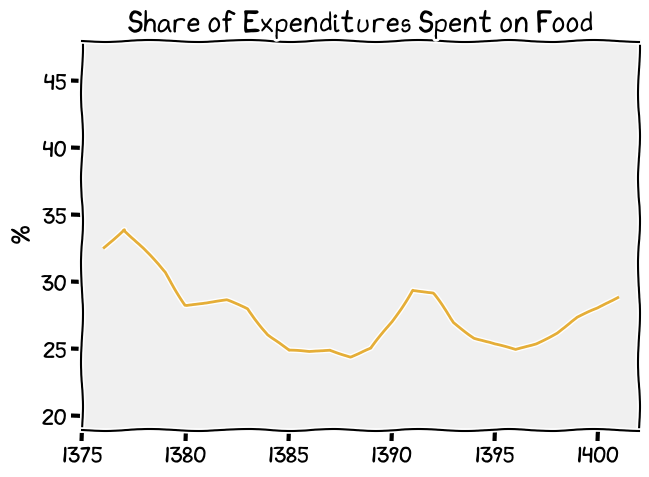

In [53]:
fig, ax = plt.subplots()

ax.plot(
    plot_3.index,
    plot_3["All"],
    color = "#e5ae38",
)

ax.set_title("Share of Expenditures Spent on Food")
ax.set_ylabel("%")
ax.set_xlim(1375, 1402)
ax.set_ylim(19, 48)

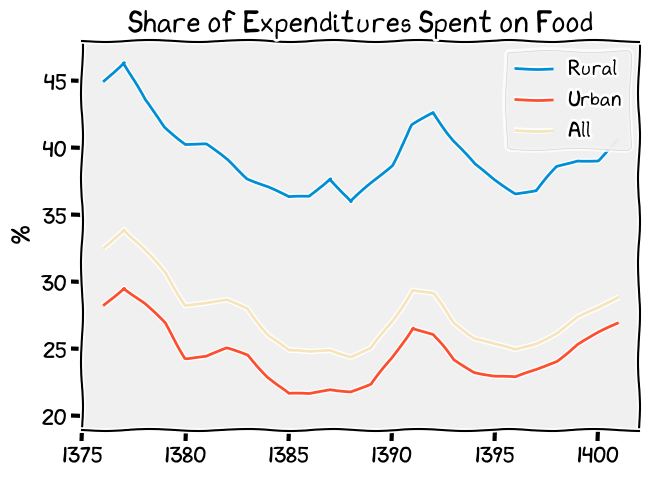

In [54]:
fig, ax = plt.subplots()
plot_data = food_ratio_data["Food_Ratio"].unstack()
ax.plot(
    plot_3.index,
    plot_3["Rural"],
    label = "Rural"
)
ax.plot(
    plot_3.index,
    plot_3["Urban"],
    label = "Urban"
)
ax.plot(
    plot_3.index,
    plot_3["All"],
    label = "All",
    alpha=0.33,
)

ax.set_title("Share of Expenditures Spent on Food")
ax.set_ylabel("%")
ax.set_xlim(1375, 1402)
ax.set_ylim(19, 48)
ax.legend()

Text(1377, 35, '')

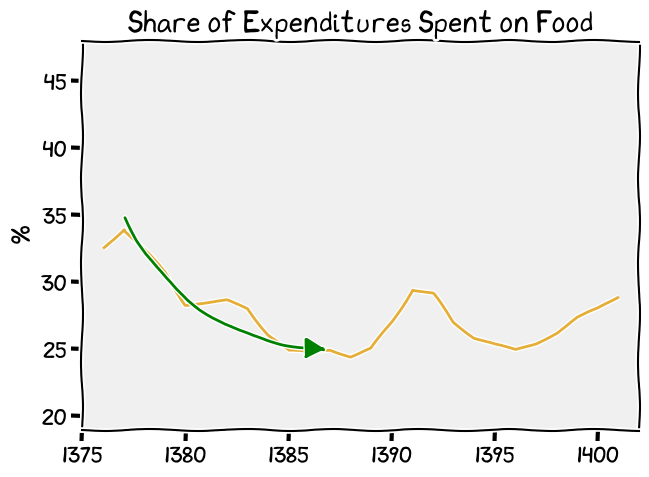

In [55]:
fig, ax = plt.subplots()
ax.plot(
    plot_3.index,
    plot_3["All"],
    color = "#e5ae38",
)

ax.set_title("Share of Expenditures Spent on Food")
ax.set_ylabel("%")
ax.set_xlim(1375, 1402)
ax.set_ylim(19, 48)


ax.annotate(
    "",
    xy=(1387, 25),
    xytext=(1377, 35),
    arrowprops = dict(
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.3",
        color="green",
        linewidth=2,
    ),
    fontsize=32,
)

Text(1387, 25, '')

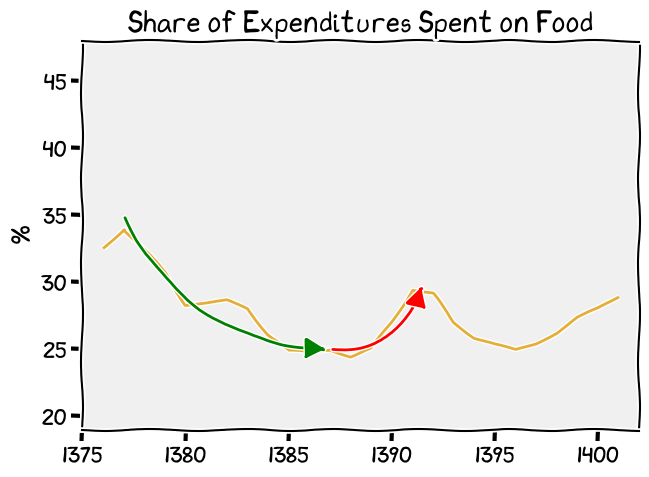

In [58]:
fig, ax = plt.subplots()
ax.plot(
    plot_3.index,
    plot_3["All"],
    color = "#e5ae38",
)

ax.set_title("Share of Expenditures Spent on Food")
ax.set_ylabel("%")
ax.set_xlim(1375, 1402)
ax.set_ylim(19, 48)


ax.annotate(
    "",
    xy=(1387, 25),
    xytext=(1377, 35),
    arrowprops = dict(
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.3",
        color="green",
        linewidth=2,
    ),
    fontsize=32,
)

ax.annotate(
    "",
    xy=(1391.5, 30),
    xytext=(1387, 25),
    arrowprops = dict(
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.4",
        color="red",
        linewidth=2,
    ),
    fontsize=32,
)

Text(1391.5, 30, '')

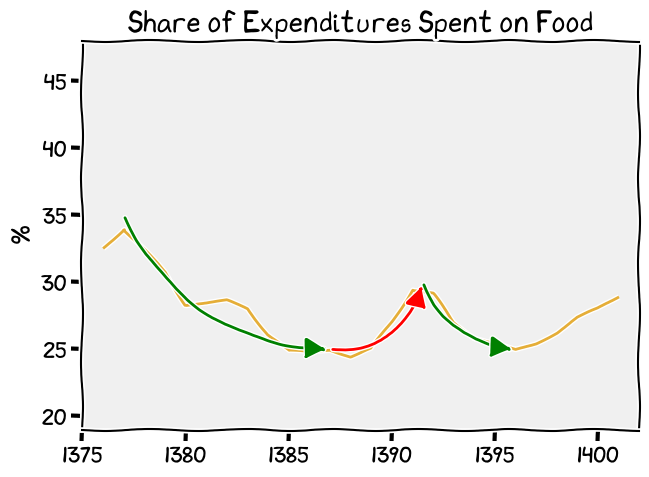

In [59]:
fig, ax = plt.subplots()
ax.plot(
    plot_3.index,
    plot_3["All"],
    color = "#e5ae38",
)

ax.set_title("Share of Expenditures Spent on Food")
ax.set_ylabel("%")
ax.set_xlim(1375, 1402)
ax.set_ylim(19, 48)


ax.annotate(
    "",
    xy=(1387, 25),
    xytext=(1377, 35),
    arrowprops = dict(
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.3",
        color="green",
        linewidth=2,
    ),
    fontsize=32,
)

ax.annotate(
    "",
    xy=(1391.5, 30),
    xytext=(1387, 25),
    arrowprops = dict(
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.4",
        color="red",
        linewidth=2,
    ),
    fontsize=32,
)

ax.annotate(
    "",
    xy=(1396, 25),
    xytext=(1391.5, 30),
    arrowprops = dict(
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.3",
        color="green",
        linewidth=2,
    ),
    fontsize=32,
)

Text(1396, 25, '')

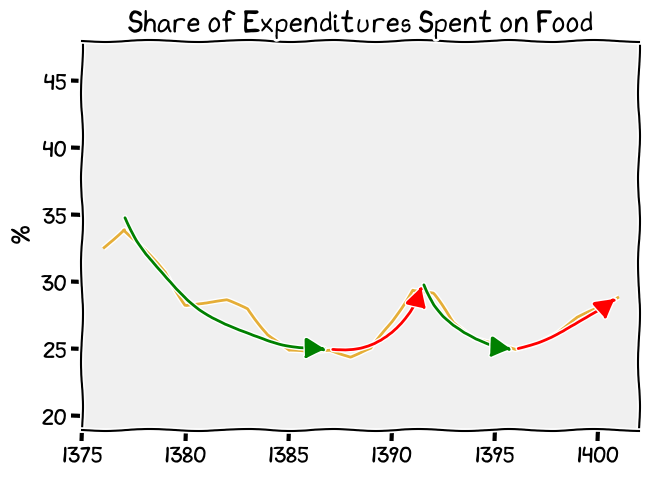

In [57]:
fig, ax = plt.subplots()
ax.plot(
    plot_3.index,
    plot_3["All"],
    color = "#e5ae38",
)

ax.set_title("Share of Expenditures Spent on Food")
ax.set_ylabel("%")
ax.set_xlim(1375, 1402)
ax.set_ylim(19, 48)


ax.annotate(
    "",
    xy=(1387, 25),
    xytext=(1377, 35),
    arrowprops = dict(
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.3",
        color="green",
        linewidth=2,
    ),
    fontsize=32,
)

ax.annotate(
    "",
    xy=(1391.5, 30),
    xytext=(1387, 25),
    arrowprops = dict(
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.4",
        color="red",
        linewidth=2,
    ),
    fontsize=32,
)

ax.annotate(
    "",
    xy=(1396, 25),
    xytext=(1391.5, 30),
    arrowprops = dict(
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.3",
        color="green",
        linewidth=2,
    ),
    fontsize=32,
)

ax.annotate(
    "",
    xy=(1401, 29),
    xytext=(1396, 25),
    arrowprops = dict(
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.1",
        color="red",
        linewidth=2,
    ),
    fontsize=32,
)

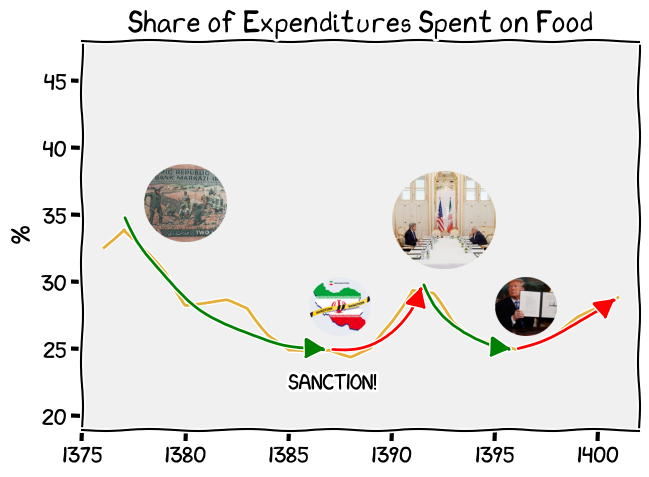

In [92]:
def make_image_circular(image):
    height, width, _ = image.shape
    y, x = np.ogrid[:height, :width]
    center_x, center_y = width // 2, height // 2
    radius = min(center_x, center_y)
    circular_mask = ((x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2)
    circular_image = np.copy(image)
    circular_image[~circular_mask] = 240
    return circular_image

def create_pic_borders(coordinate: tuple[int, int], size: int) -> tuple[int, int, int, int]:
    return (
        coordinate[0],
        coordinate[0] + size,
        coordinate[1],
        coordinate[1] + size / (1402 - 1375) * (48 - 19) * 1.35,
    )

fig, ax = plt.subplots()
ax.plot(
    plot_3.index,
    plot_3["All"],
    color = "#e5ae38",
)

ax.set_title("Share of Expenditures Spent on Food")
ax.set_ylabel("%")
ax.set_xlim(1375, 1402)
ax.set_ylim(19, 48)


ax.annotate(
    "",
    xy=(1387, 25),
    xytext=(1377, 35),
    arrowprops = dict(
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.3",
        color="green",
        linewidth=2,
    ),
    fontsize=32,
)

ax.annotate(
    "",
    xy=(1391.5, 30),
    xytext=(1387, 25),
    arrowprops = dict(
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.4",
        color="red",
        linewidth=2,
    ),
    fontsize=32,
)

ax.annotate(
    "",
    xy=(1396, 25),
    xytext=(1391.5, 30),
    arrowprops = dict(
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.3",
        color="green",
        linewidth=2,
    ),
    fontsize=32,
)

ax.annotate(
    "",
    xy=(1401, 29),
    xytext=(1396, 25),
    arrowprops = dict(
        arrowstyle="-|>",
        connectionstyle="arc3,rad=0.1",
        color="red",
        linewidth=2,
    ),
    fontsize=32,
)

revelotion = make_image_circular(mpl.image.imread("pics/1.jpg"))
ax.imshow(revelotion, aspect='auto', extent=create_pic_borders((1378, 33), 4))

revelotion = make_image_circular(mpl.image.imread("pics/2.jpg"))
ax.imshow(revelotion, aspect='auto', extent=create_pic_borders((1386, 26), 3))

ax.text(x=1385, y=22, s="SANCTION!")

revelotion = make_image_circular(mpl.image.imread("pics/3.jpg"))
ax.imshow(revelotion, aspect='auto', extent=create_pic_borders((1390, 31), 5))

revelotion = make_image_circular(mpl.image.imread("pics/4.jpg"))
ax.imshow(revelotion, aspect='auto', extent=create_pic_borders((1395, 26), 3))